<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
# import plotly.express as px
%matplotlib inline

from sklearn.metrics import cohen_kappa_score, roc_curve, f1_score, make_scorer

<h3> Read in the data, store if dataframe

In [2]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

<h4>Tidying

In [3]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

# print(len(df[df['gender'] == 'other']))
## drop the one row that has "other" gender to keep things simple
df.drop(index=df[df['gender'] == 'other'].index, inplace=True)

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

## round off age
df['age'] = df['age'].apply(lambda x : round(x))

# cap BMI outliers to a maximum of 60 
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h4>Imputing

In [4]:
m_df = df[df['gender'] == 'male']
f_df = df[df['gender'] == 'female']

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 'male':
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]

In [5]:
residence_type_map = {
    'urban':0,
    'rural':1
}
df['residence_type'] = df['residence_type'].map(residence_type_map)
# replace marital status with binary values
df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})
# replace gender with binary values
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h4>Binning

In [6]:
# implement age bins
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)

# implement glucose bins
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# implement bmi bins
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)

In [7]:
def add_dummy(target_df, origin_df, col):
    abbrev = col[:2] + '_'
    for cat in origin_df[col].value_counts().index.tolist()[1:]:
        target_df[abbrev + str(cat)] = origin_df[col] == cat
        target_df[abbrev + str(cat)] = target_df[abbrev + str(cat)].map({False: 0, True: 1})


In [8]:
df_dummies = pd.DataFrame(index=df.index)

# add_dummy(df_dummies, df, 'work_type')
# add_dummy(df_dummies, df, 'smoking_status')
add_dummy(df_dummies, df, 'age_bin')
add_dummy(df_dummies, df, 'avg_glucose_level_bin')
# add_dummy(df_dummies, df, 'bmi_bin') REMOVED TO TEST FEATURE SELECTION

In [9]:
# to_add = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'stroke']
to_add = ['hypertension', 'heart_disease', 'stroke']
df_dummies[to_add] = df[to_add]

In [10]:
df_dummies.head()

,"ag_(20.0, 30.0]","ag_(-0.1, 11.0]","ag_(30.0, 38.0]","ag_(38.0, 45.0]","ag_(51.0, 57.0]","ag_(65.0, 75.0]","ag_(11.0, 20.0]","ag_(75.0, 82.0]","ag_(45.0, 51.0]","av_(80.0, 85.6]",...,"av_(192.2, 271.7]","av_(124.1, 192.2]","av_(55.0, 65.8]","av_(108.5, 124.1]","av_(91.9, 98.9]","av_(85.6, 91.9]","av_(73.8, 80.0]",hypertension,heart_disease,stroke
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1


In [111]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import recall_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB, MultinomialNB

In [112]:
def nb_cv(model, X, y, scorer='roc_auc', splits=3, repeats=5):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=1)

    scores = cross_val_score(model, X, y, scoring=scorer, cv=cv, n_jobs=-1)
    
    return scores

In [113]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(['stroke'], axis=1), df_dummies['stroke'], test_size=0.33, random_state=42)

In [114]:
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

## Oversampling for kNN
As features are all dummies, random oversampling seemed to make more sense than SMOTE (although i think they had similar results)

In [115]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## Model selection
Bernouulli NB was used because it's designed for binary features

In [124]:
clf = BernoulliNB()
scores = nb_cv(clf, X_resampled, y_resampled, scorer='recall')
clf.fit(X_resampled, y_resampled)

BernoulliNB()

## ROC AUC scores and confusion matrix

In [125]:
scores

array([0.78899083, 0.80275229, 0.80825688, 0.80825688, 0.80091743,
       0.79082569, 0.80458716, 0.78715596, 0.80825688, 0.80275229,
       0.78440367, 0.81284404, 0.79357798, 0.80733945, 0.79908257])

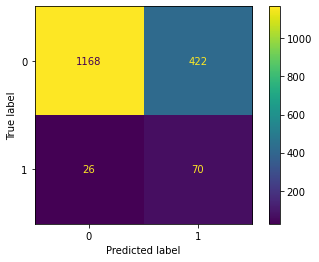

In [126]:
plot_confusion_matrix(clf, X_test, y_test)

## Looking at the top 10 relevant features for each class found by model

In [127]:
print("Order of probability in positive class")
print(*np.take(X_train.columns, pos_class_prob_sorted), sep="\n")
print("Order of probability in negative class")
print(*np.take(X_train.columns, neg_class_prob_sorted), sep="\n")

Order of probability in positive class
ag_(75.0, 82.0]
ag_(65.0, 75.0]
av_(192.2, 271.7]
hypertension
heart_disease
av_(124.1, 192.2]
ag_(51.0, 57.0]
av_(91.9, 98.9]
av_(73.8, 80.0]
av_(65.8, 73.8]
av_(108.5, 124.1]
av_(55.0, 65.8]
av_(80.0, 85.6]
av_(85.6, 91.9]
ag_(45.0, 51.0]
ag_(38.0, 45.0]
ag_(30.0, 38.0]
ag_(-0.1, 11.0]
ag_(11.0, 20.0]
ag_(20.0, 30.0]
Order of probability in negative class
ag_(20.0, 30.0]
ag_(-0.1, 11.0]
ag_(30.0, 38.0]
ag_(38.0, 45.0]
av_(73.8, 80.0]
av_(80.0, 85.6]
av_(65.8, 73.8]
av_(55.0, 65.8]
av_(85.6, 91.9]
av_(124.1, 192.2]
ag_(11.0, 20.0]
av_(108.5, 124.1]
av_(91.9, 98.9]
ag_(51.0, 57.0]
ag_(45.0, 51.0]
ag_(65.0, 75.0]
av_(192.2, 271.7]
hypertension
ag_(75.0, 82.0]
heart_disease


## Creating a new dataset with the top six relevant features for positive and negative class

In [128]:
selected = [*np.take(X_train.columns, pos_class_prob_sorted)[:6], *np.take(X_train.columns, neg_class_prob_sorted)[:6], 'stroke']

In [129]:
df_trimmed = df_dummies[selected]

In [130]:
X_train_trimmed, X_test_trimmed, y_train_trimmed, y_test_trimmed = train_test_split(df_trimmed.drop(['stroke'], axis=1), df_trimmed['stroke'], test_size=0.33, random_state=42)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_trimmed, y_train_trimmed)

In [131]:
clf_trimmed = BernoulliNB()
scores = nb_cv(clf_trimmed, X_resampled, y_resampled, scorer='recall')
clf_trimmed.fit(X_resampled, y_resampled)

BernoulliNB()

In [132]:
scores

array([0.76146789, 0.77247706, 0.78807339, 0.77981651, 0.77614679,
       0.76605505, 0.78073394, 0.75504587, 0.78623853, 0.77522936,
       0.75963303, 0.78715596, 0.7412844 , 0.78440367, 0.76972477])

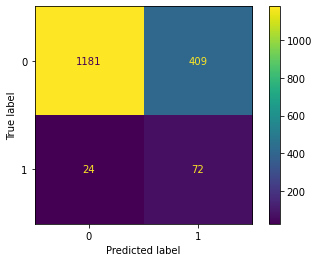

In [133]:
plot_confusion_matrix(clf_trimmed, X_test_trimmed, y_test_trimmed)

## Result
The confusion matrix only looks slightly better. Somehow the scores look worse though. To be tested some more